# QISKIT - Quantum representations implementation tutorial

During this tutorial, I will explain and implement some quantum encoding algorithms from ["Quantum image representation: a review"](https://www.researchgate.net/publication/366599323_Quantum_image_representation_a_review) article from Marina Lisnichenko and Stanislav Protasov.
All of the implemented code comes from the referenced Github in this article: [repository link](https://github.com/UralmashFox/QPI)

### Packages installation

For this tutorial, we will require the installation of this packages

In [ ]:
pip install math
pip install numpy
pip install matplotlib
pip install qiskit-aer
pip install qiskit=="0.46"
pip install qiskit[visualization]

 As a clarification, the used Qiskit version is outdated as of today, but it is needed for now because of all the changes that the functions suffered, making it impossible to adapt in some implementations. Likewise, the algorithms core concepts are inherently the same.

### Libraries import

All the dependencies we will need for the execution of the code.
The ibm_washington_config and ionq_config files are all available in the repository folder.

In [1]:
import numpy as np

import math
from math import pi

import qiskit
from qiskit.extensions import XGate
from qiskit import transpile, assemble
from qiskit.visualization import circuit_drawer
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer, IBMQ, execute
from qiskit.circuit.library.standard_gates.ry import RYGate
from qiskit.tools.visualization import plot_bloch_multivector

import matplotlib.pyplot as plt

from ionq_config import coupling_map, basis_gates

from ibm_washington_config import coupling_map, basis_gates

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_8384\3763628279.py:7: DeprecationWarning: The qiskit.extensions module is deprecated since Qiskit 0.46.0. It will be removed in the Qiskit 1.0 release.
  from qiskit.extensions import XGate


### Auxiliary functions

This first function creates the different example images that will be used during the tutorial. The images have different characteristics according to the algorithm complexity.

In [2]:
def image_generate(arg):
    if(arg == "smallest"):
        return np.random.uniform(low=0, high=255, size=(2,2)).astype(int) # The image is generated in grayscale
    if(arg == "small"):
        # Used by the costly Qubit Lattice representation.
        return np.random.uniform(low=0, high=255, size=(4,4)).astype(int)
    if(arg == "normal"):
        # Used mostly by mixed representation algorithms.
        return np.random.uniform(low=0, high=255, size=(8,8)).astype(int)
    if(arg == "color"):
        # Only used by algorithms that can treat RGB channels, like MCRQI or BRQI.
        return np.random.uniform(low=0, high=255, size=(8,8,3)).astype(int)

This next function aims to compare the output image generated by the quantum circuit with the original input image. It prints the results as an image and as an array, to see how close the generated results are with the real ones. 

In [3]:
def plot_to_compare(output_im, input_im):
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(output_im, cmap='gray')
    plt.title('Measured Image')

    plt.subplot(2, 2, 2)
    plt.imshow(input_im, cmap='gray')
    plt.title('Real Image')

    diff_img = input_im - output_im
    plt.subplot(2, 2, 3)
    plt.imshow(diff_img, cmap='gray')
    plt.title('Difference Image')

    plt.subplot(2, 2, 4)
    plt.text(0.5, 0.5, str(diff_img), fontsize=12, ha='center', va='center', color='black')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Lastly, the backend_sim function, which objective is unify the same execution process that is created in every representation below, the backend execution and the real quantum circuit simulation.
This last function will be explained more deeply during the algorithms description.

In [4]:
def backend_sim(qc, backend, shots):
    t_qc = transpile(qc, backend)
    qobj = assemble(t_qc, shots=shots)
    job = backend.run(qobj)
    result = job.result()
    counts = result.get_counts()
    return result, counts

# Introduction

In this section, the main parts of a quantum image encoding algorithm will be deconstructed in detail, in order to facilitate the subsequent explanations.

As an starting point, we will see some of the important elements used by the different implementations.

### Registers

In order to work with quantum algorithms, it is needed to declare the number of qubits our circuits require.

In [5]:
QuantumReg = QuantumRegister(5, 'QReg') # 1st argument -> nº qubits; 2nd argument -> label
ClassicalReg = ClassicalRegister(5, 'ClReg')

### Quantum circuit

Quantum circuits are the backbone of quantum algorithms. They represent the main structure where the quantum data is represented, manipulated and converted into a classical representable result.

In [6]:
QC = QuantumCircuit(QuantumReg, ClassicalReg)

C:\Users\jfcoa\anaconda3\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


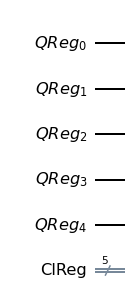

In [7]:
QC.draw(output='mpl')

### Quantum gates

Quantum logic gates are fundamental circuits that operate on qubits, similar to classical logic gates in digital circuits. They are described as unitary operators represented by unitary matrices relative to an orthonormal basis, typically the computational basis, which uses binary notation for labeling basis vectors.

In a practical context, they act directly with the qubit, rotating its angle in the bloch state matrix.

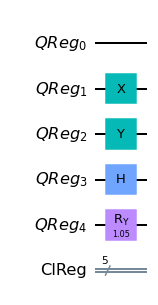

In [8]:
QC.x(1) # X-Gate -> argument corresponds to the target qubit
QC.y(2) # Y-Gate
QC.h(3) # Hadamard Gate
QC.ry(1.05,4) # RY-Gate -> 1st argument corresponds to the rotating angle
QC.draw(output='mpl')

After that, we generate the results using a simulated quantum device.

In [9]:
result = execute(QC, Aer.get_backend('statevector_simulator')).result()

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_8384\3273368251.py:1: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  result = execute(QC, Aer.get_backend('statevector_simulator')).result()
C:\Users\jfcoa\AppData\Local\Temp\ipykernel_8384\3273368251.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(QC, Aer.get_backend('statevector_simulator')).result()


In [10]:
statevector = result.get_statevector()

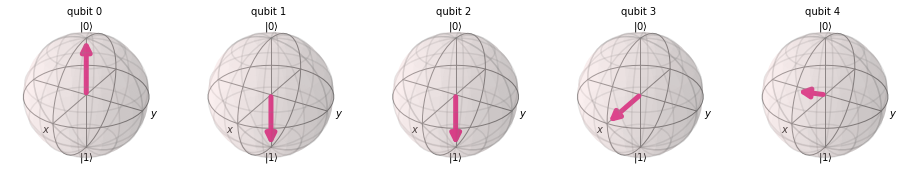

In [11]:
plot_bloch_multivector(statevector)

But how we represent this data?

Initally, qubits have two possible basis states: 0 and 1; and these are represented in the bloch sphere shown before. For example, a qubit with basis state 0 when we apply the X or the Y gate it rotates to basis state 1.

In [12]:
QC = QuantumCircuit(1, 1)

In [13]:
QC.measure([0], [0])
counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_8384\3286676961.py:2: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()


Every time we look up to the results of a certain quantum machine, we look up to the counts, a parameter that contains all the states which were generated by the quantum system and how many times they were measured. This is important because a quantum computer works as a probability machine, the number of counts of each state compared to the total sum of counts equals to a probability value.

In [14]:
print(counts)

{'0': 100}


In this case, because we didn't use any gate to alterate the basis state of the qubit, every count has been in the 0 state.

In [15]:
QC.x(0)

In [16]:
QC.measure([0], [0])
counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()
print(counts)

{'1': 100}


C:\Users\jfcoa\AppData\Local\Temp\ipykernel_8384\4027092522.py:2: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()


Now, as we have said before, the X gate takes the basis state all the way to the 1 value. But, what happens if the apply an Ry or Rx gate?

In [17]:
QC.ry(1.25, 0)

In [18]:
QC.measure([0], [0])
counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()
print(counts)

{'0': 38, '1': 62}


C:\Users\jfcoa\AppData\Local\Temp\ipykernel_8384\4027092522.py:2: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()


As we can see, the counts are now divided and corresponds to a probability of being in one of the two possible states.

If we look closely, when RY-Gate application is declared, it requires 2 values instead of 1, as the other gates. The reason is that this type of gate needs the user to specify the rotation value, so the parameter must be between 0 and $\pi$.

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_8384\921772064.py:6: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(QC, Aer.get_backend('statevector_simulator')).result()


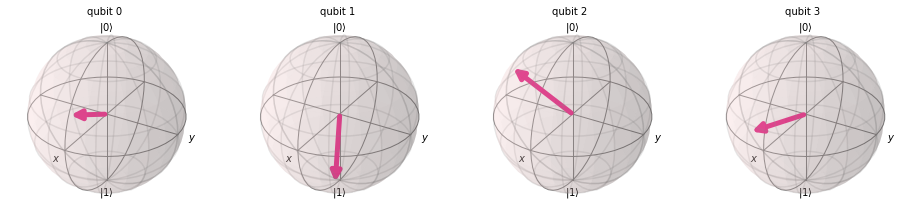

In [22]:
QC = QuantumCircuit(4, 4)
QC.ry(1.12, 0)
QC.ry(3.02, 1)
QC.rx(1.12, 2)
QC.rx(2.12, 3)
result = execute(QC, Aer.get_backend('statevector_simulator')).result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

This is the most relevant property to this project, because it will be used to treat the input quantum data, transform it, and generate the output classical data we want. 

# Types of representation

In the field of quantum image embedding, there are four types of representations: 
- Mixed 
- Continuous 
- Discrete 
- Phase (Fourier Transformation)

Each one has its unique characteristics and complexity. During the next steps of this tutorial we will see this different groups and how they treat the data and are implemented.

# Mixed representation

 ## [Qubit Lattice](https://doi.org/10.1117/12.485960)

As an introduction to this topic, Qubit Lattice, a mixed representation algorithm, can help to understand some basic concepts, being one of the reasons the fact that, this application, doesn't use advanced quantum properties like entaglement or superposition, which will be seen as we proceed with the tutorial.

 ### Image generation 

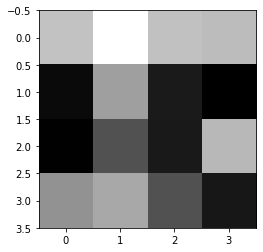

In [71]:
image = image_generate("small")
plt.imshow(image, cmap = 'gray')
signal = image.flatten() # this function reduces the dimensionality of the array, so we work with 1 dimension instead of 2
signal = np.interp(signal, (0, 255), (0, np.pi)) # converts the 0-255 value range of a grayscaled image into 0-pi range

It is necessary to transform the values into [0-$\pi$] range, because qubits use angles in order to rotate or represent the different pixel values.

### Quantum circuit building

In order to build the quantum circuit, we have to follow these steps:
1. Declare the qubits required for the input image (the number varies between algorithms).
2. Declare the classical bits required, the number corresponds to the same as of the qubits.
3. Create the quantum circuit.
4. Initialize the circuit, if its required.
5. Apply rotations to the different qubits using gates, corresponding to the applied algorithms theory.
6. Carry out the measurement to output our results in classical bits.

Regarding this algorithm, the qubits required are $2^{2n}$ for representing a $2^{n}$ x $2^{n}$ image.

In [72]:
# 1. Required qubits declaration
color = QuantumRegister(len(signal), 'color')

# 2. Classical bits declaration
classic = ClassicalRegister(color.size, 'classic')

# 3. Quantum circuit implementation 
qc = QuantumCircuit(color, classic)

# 4. In this example, the circuit initialization isn't required due to the simplicity of the circuit

# 5. Rotation gates application
for i, ang in enumerate(signal):
    qc.ry(ang, i) # RY-Gate application -> rotates the state along the Y-axis

# 6. Measurement 
qc.measure(list(reversed(range(len(signal)))), range(len(signal)))

The first input value in the measure function is reversed because the less significative bit is located in the first position of the qubit state array.

During comparisons between circuits, depth is a relevant factor because it represents the longest path in the circuit(the path length is always an integer number, representing the number of gates it has to execute in that path), which is important in the optimization field.

In [73]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

depth is 2, # of qubits is 16


In order to match the topology of an specific quantum device or/and optimize the circuit for execution on present day noisy quantum systems, it is required to rewrite the given input circuit. This process is called transpilation.

In [74]:
wash_qc = transpile(circuits=qc, coupling_map=list(coupling_map)[0], basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))

depth is 2


With this command you can visualize the transpiled quantum circuit.

C:\Users\jfcoa\anaconda3\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


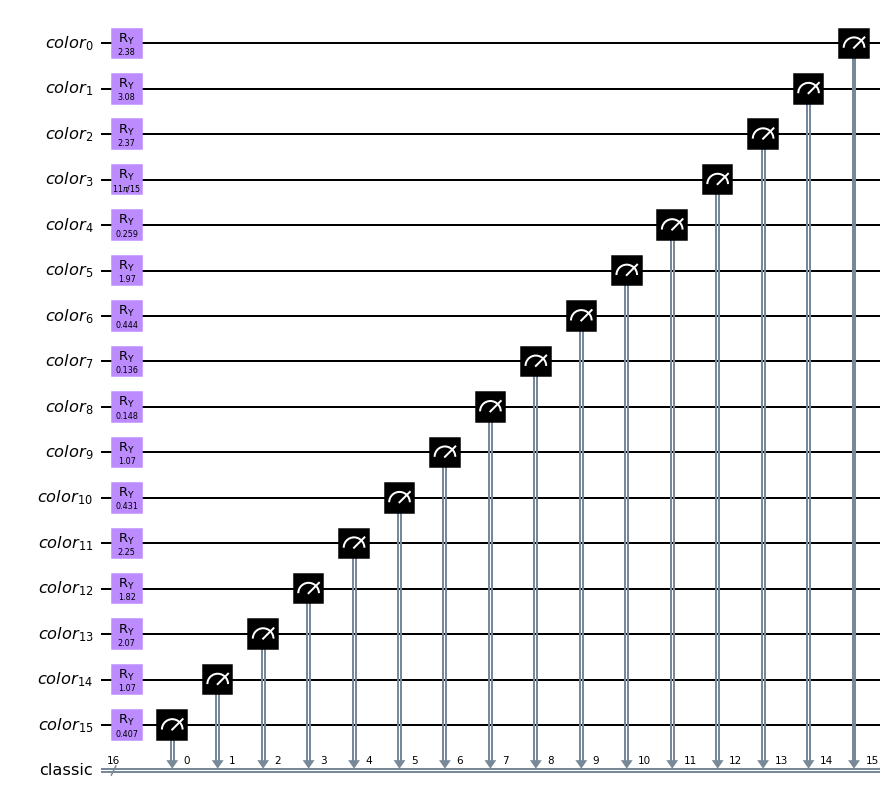

In [75]:
qc.draw('mpl')

In the following algorithms, this instruction won't be used due to the increase of quantum circuit lenght and depth, making the notebook unreadable, but it can be tested freely for everyone.

### Backend simulations

Backend are the responsibles of running the quantum circuits, simulating the different states and returning results.
During this tutorial we will use a backend simulator called "aer_simulator". Simulators are software applications that emulate the behaviour of real quantum devices, in order to debug and algorithms before using them in valuable quantum hardware, due to their costs. 

In [76]:
shots = 1000000
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc, backend, shots)

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_8384\1756418184.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


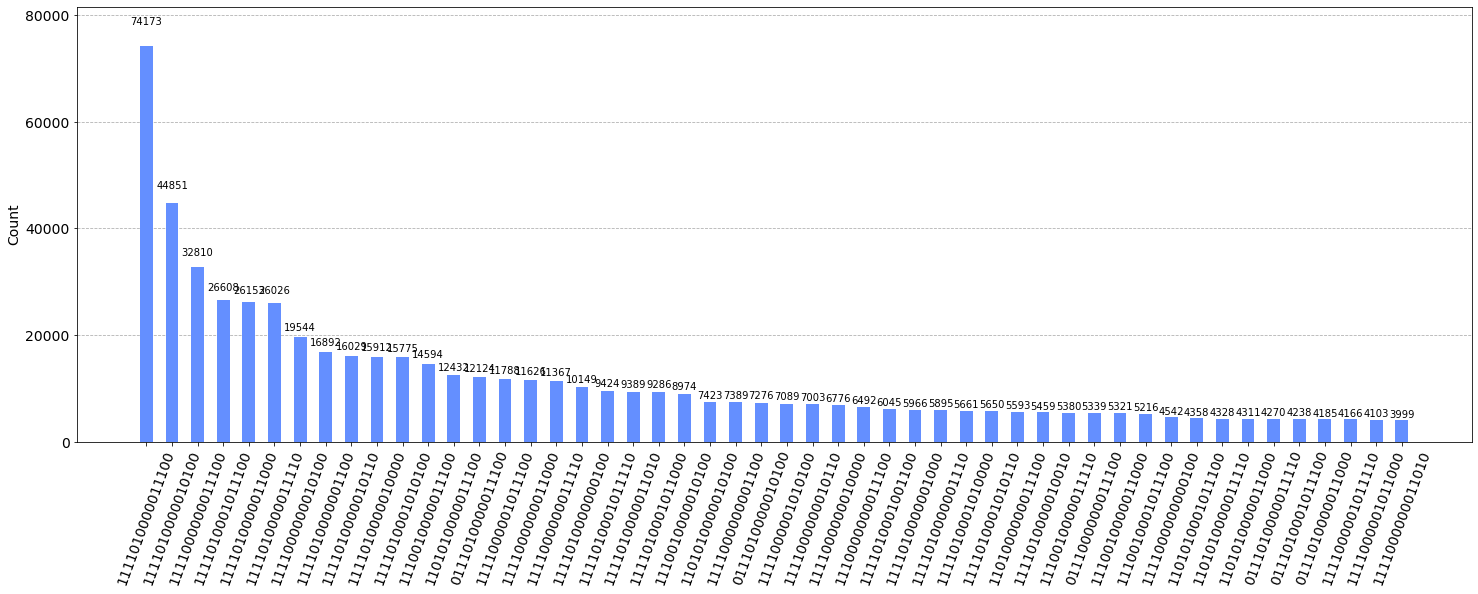

In [77]:
plot_histogram(counts, figsize=(25,8), sort="value_desc", number_to_keep=50)

And, now? How do we work with these values?

<img src="images/ruan_mei.webp" alt="drawing" width="200" style="float: left;"/>

## Results treatment

The results we have already seen in counts are the different qubit states equal to the result image color structure. The values 0 and 1 represent black and white(0 and 255), and the values in between are approximated to them. For example, if the color value of the pixel is 130 it will be translated as 1 when we analyze the result, because it is closer to the value in question.
The reason about this is that the rest of the information about the pixel color is stored in the probabilites obtained from the circuit. 


Let's analyze this more deeply...

In [78]:
pixels = np.zeros((len(signal)))
for item in counts:
    for i, bit in enumerate(item):
        if bit=='0':
            pixels[i]+=counts[item]

In [79]:
print(pixels)

[1.38639e+05 9.63000e+02 1.42710e+05 1.65708e+05 9.83197e+05 3.05490e+05
 9.51599e+05 9.95468e+05 9.94602e+05 7.38264e+05 9.54353e+05 1.84604e+05
 3.75400e+05 2.60402e+05 7.38974e+05 9.59270e+05]


What we have done here is getting all the 255 values in every qubit state, and applying its count value (their probabilities) to a pixel array with the image size.

Now, in the next step we will translate this values into angles.

In [80]:
reconstruct = []
for pixel in pixels:
    
    color = 2*np.arccos((pixel/shots)**(1/2)) # "shots" corresponds to the total counts value.
    reconstruct.append(color)
print(reconstruct)

[[193 249 192 186]
 [ 21 159  36  10]
 [ 11  87  34 182]
 [147 168  87  32]]


And now that we have the values translated into angles, we have to convert them again into the [0-255] range of grayscale values.

In [ ]:
reconstruct = list(np.interp(reconstruct, (0, np.pi), (0, 255)).astype(int))
reconstruct = np.reshape(reconstruct, (4,4))
print(reconstruct)

### Input and measured images comparison

Finally, we can see the final result!

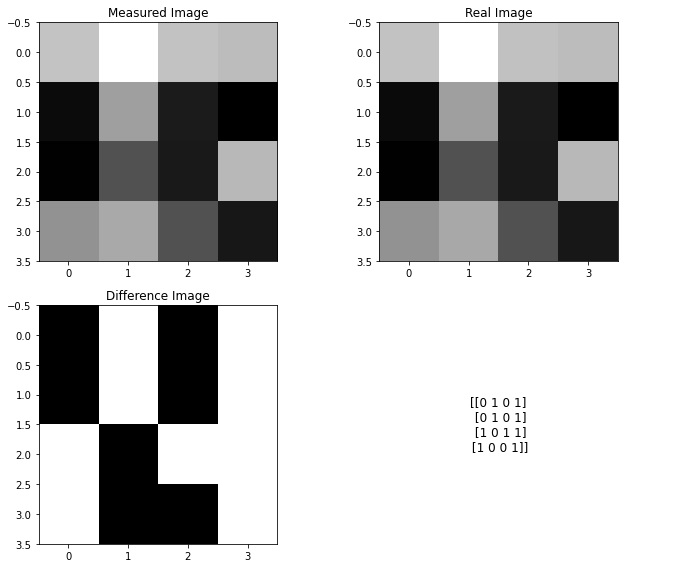

In [81]:
plot_to_compare(reconstruct, image)

How was it? Was it difficult? I hope that it wasn't because we are only getting started...

<img src="images/horror.webp" alt="drawing" width="200" style="float: left;"/>

## [FRQI](https://link.springer.com/content/pdf/10.1007/s11128-010-0177-y.pdf) - Flexible representation of quantum images

### Representation equation $| I(\theta)\rangle = \frac{1}{2^n}\sum_{i=0}^{2^{2n}-1}(cos\theta_i | 0 \rangle + sin\theta_i | 1 \rangle) \otimes | i \rangle$, where

$\theta_i$ - continuous representation of the intensity,

$i$ - binary expansion of the pixel coordinate.

### Image generation

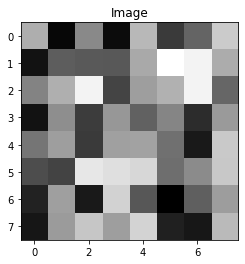

In [72]:
image = image_generate("normal")
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

### Image treatment and qubits calculation

In this example, the qubit state values will represent the possible pixel coordinate values.

In [73]:
# Image flattening into 1D vector for convenience and simplicity.
input_im = image.copy().flatten()

# Transform the normalized values into angles
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))

# Number of required qubits needed 
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

### Quantum circuit building

1. Initialize our qubits using the Hadamard gate to make them enter in a superposition state.
2. Create all possible qubit states.
3. Apply the required rotations.

The implementation of the FRQI needs to implement a $C^{n}(R_{y}(θ))$ gate for al the $2^{2n}$ pixels in the image. The way we do this is by changing the state of the pixel position qubits, for example, an image of $2\times2$ has 2 qubits, we have to change the states of those two qubits until we have gone through all the pixels in the image, i.e., "00000000", "01000010", "10100010", ..., "11111111". 

In [74]:
# Sets the qubits needed for the circuit
O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg') # target qubit

# Sets the bits that will hold the measurements result
cr = ClassicalRegister(O.size+c.size, "cl_reg")

# Creates the quantum circuit
qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits

# Applies quantum gates to each initial qubit in the circuit
qc_image.h(O) # h -> Hadamard gate

# Creates an array of qubits
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    # Generate the different possible states of our qubits(coordinates)
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        # Look up to each qubit state
        if int(qub_ind):
            qc_image.x(O[k])# Apply X-gate to qubits in state '1'
    qc_image.barrier()
    
    # Applies the Ry multi-controlled gate to all the circuit qubits
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])
    
    qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

In [75]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 640, # of qubits is 7


In [76]:
wash_qc = transpile(circuits=qc_image, coupling_map=list(coupling_map)[0], basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))

depth is 10327


In [77]:
# qc_image.draw('mpl')

### Backend simulation

In [78]:
shots = 20000
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc_image, backend, shots)

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_8608\1756418184.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


In [79]:
print(counts)

{'1101101': 291, '0010001': 128, '0001101': 331, '0111100': 301, '0100100': 104, '1110111': 5, '1001011': 75, '0010111': 263, '1101011': 242, '0010010': 188, '1111000': 274, '0111111': 74, '0100001': 304, '1110010': 318, '0001010': 323, '0000111': 287, '1011011': 203, '0011001': 301, '0111110': 318, '0100010': 153, '1001101': 9, '1110001': 309, '1100100': 197, '0101010': 66, '0110110': 216, '1000111': 7, '1111011': 229, '0000001': 300, '1101111': 152, '0100000': 133, '1111111': 255, '1000011': 275, '0011101': 313, '0100110': 140, '0111010': 260, '0001111': 291, '1110101': 95, '1010000': 261, '1010100': 296, '1011000': 280, '1110000': 228, '1001110': 217, '0100011': 214, '0111101': 138, '0101100': 250, '0110100': 238, '1000101': 275, '1011111': 130, '1110100': 84, '0100111': 279, '0011011': 113, '1010001': 171, '1100101': 33, '0110101': 231, '0101011': 113, '1111010': 35, '1000100': 208, '0111001': 189, '1001000': 230, '0011111': 184, '1101000': 111, '1111001': 95, '1101001': 306, '1010

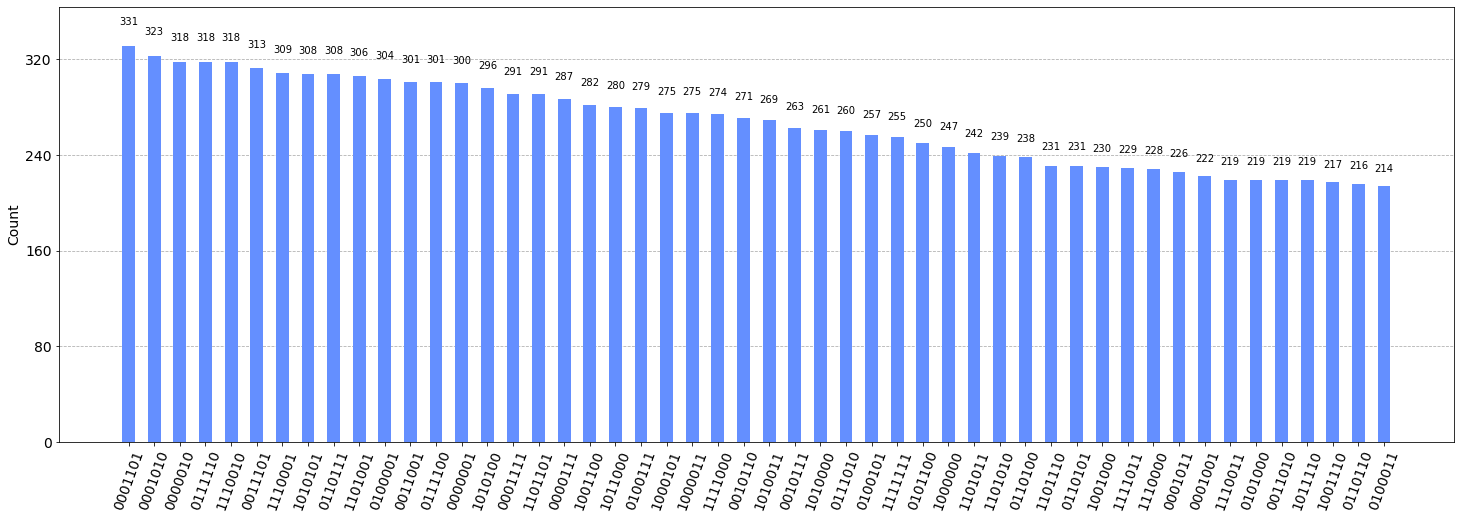

In [80]:
plot_histogram(counts, figsize=(25,8), sort="value_desc", number_to_keep=50)

### Input and measured images comparison

In [89]:
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))

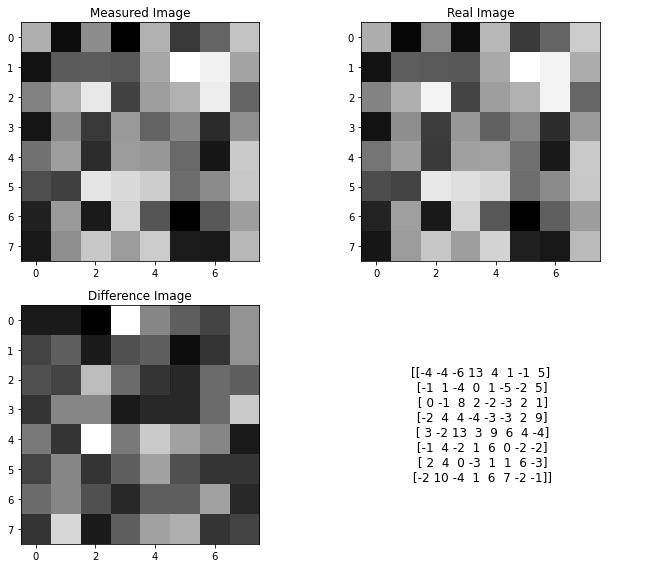

In [90]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)

## [MCRQI](https://www.overleaf.com/project/61911febed45e965f929d7c0#cite.sun2011multi) - Multi-channel Representation for Images

### Image generation

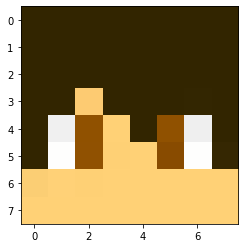

In [8]:
image = plt.imread('demo.jpg')
plt.imshow(image)
plt.show()

### Qubits calculation

In [9]:
xqbits = math.log(image.shape[0],2)
yqbits = math.log(image.shape[1],2)
xqbit = int(xqbits)
yqbit = int(yqbits)

### Quantum circuit building

In [10]:
qr = QuantumRegister(xqbit + yqbit + 3) #3 stands for RGB qubits
color = qr[xqbit + yqbit:]
coordinate = qr[:xqbit + yqbit]
cr = ClassicalRegister(xqbit + yqbit + 3, 'c')
qc = QuantumCircuit(qr, cr)

for k in range(int(np.floor((xqbit + yqbit)/2))):
    qc.swap(k,xqbit + yqbit - 1 - k)

for i in range(xqbit + yqbit):
    qc.h(i)

for layer_num, input_im in enumerate(image.T):
    input_im = input_im.flatten()
    input_im = np.interp(input_im, (0, 255), (0, np.pi/2))

    for i, pixel in enumerate(input_im):
        arr = list(range(xqbit + yqbit))
        arr.append(int(xqbit + yqbit + layer_num))
        cMry = RYGate(2*pixel).control(xqbit + yqbit)

        to_not = "{0:b}".format(i).zfill(xqbit + yqbit)
        for j, bit in enumerate(to_not):
            if int(bit):
                qc.x(j)
        qc.barrier()
        qc.append(cMry, arr)

        if i!=len(input_im)-1 or layer_num!=2:
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)
            qc.barrier()

for k in range(int(np.floor((xqbit + yqbit)/2))):
    qc.swap(k, xqbit + yqbit - 1 - k)

qc.swap(-1, -3)

qc.barrier()
for i in range(xqbit + yqbit + 3):
    qc.measure(i, i)

In [11]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

depth is 573, # of qubits is 9


In [12]:
wash_qc = transpile(circuits=qc, coupling_map=list(coupling_map)[0], basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))

depth is 36166


C:\Users\jfcoa\anaconda3\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


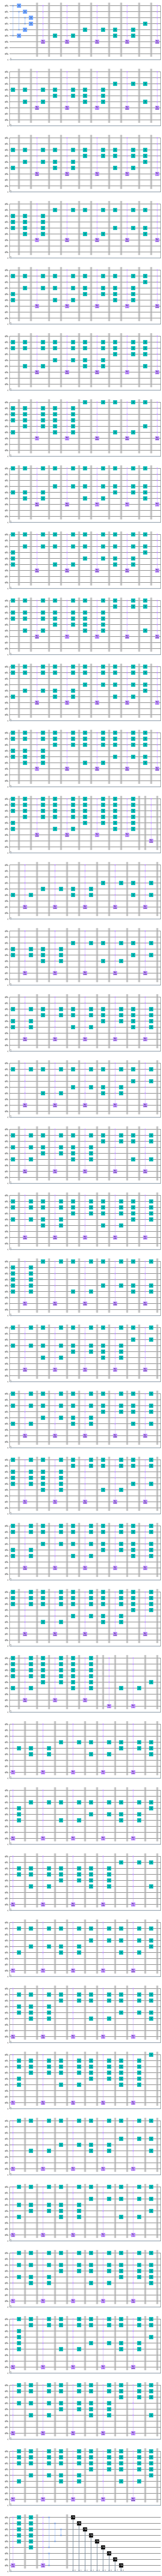

In [13]:
qc.draw('mpl')

### Backend simulation

In [14]:
shots = 1000
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc, backend, shots)

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_10116\4150664816.py:2: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  backend = Aer.get_backend('aer_simulator')
C:\Users\jfcoa\AppData\Local\Temp\ipykernel_10116\1756418184.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


### Input and measured images comparison

In [40]:
def reconstruct_rgb(image, counts, to_print=True):
    output_ims = []
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        nums = []
        for iter in range(len(input_im)):
            flag = 0
            num = []
            for item in counts.items():
                if int(item[0][3:], 2)==iter: 
                    num.append((int(item[0][layer_num], 2), item[1]))
            nums.append(num)
        for l, num in enumerate(nums):
            my_set = {x[0] for x in num}
            nums[l] = [(i,sum(x[1] for x in num if x[0] == i)) for i in my_set]
        colors = []
        for num in nums:
            if len(num)==2:
                if num[0][0] == 0:
                    color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
                else:
                    color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
            else:
                if num[0][0] == 0:
                    colors.append(0)
                else:
                    colors.append(np.pi/2)            
        output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
        if to_print:
            print(output_im, '\n', (image.T)[layer_num].copy().flatten())
        output_ims.append(output_im.reshape(image[:,:,0].shape))
    
    return np.array(output_ims).T

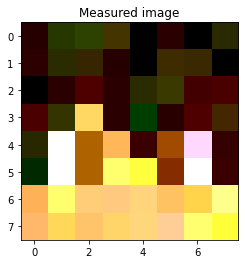

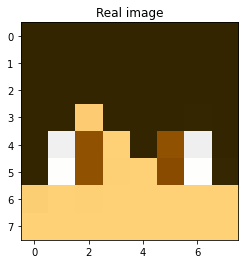

In [41]:
output_ims = reconstruct_rgb(image, counts, to_print = False)
plt.imshow(output_ims)
plt.title('Measured image')
plt.show()
plt.title('Real image')
plt.imshow(image)
plt.show()

# Continous Representation examples

## QSMC_QSNC

### Image generation

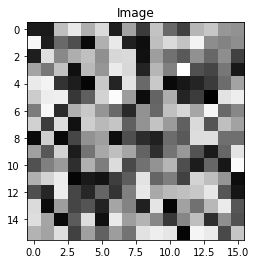

In [81]:
image = image_generate("normal")
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

In [82]:
im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

### Quantum circuit building

In [83]:
num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1

In [84]:
O = QuantumRegister(num_ind_bits, 'o_reg')
color = QuantumRegister(1,'color')
coordinate = QuantumRegister(1, 'coordinate')
cr = ClassicalRegister(O.size+color.size+coordinate.size, "cl_reg")

qc_image = QuantumCircuit(color, coordinate, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(color)
qc_image.i(coordinate)
qc_image.h(O)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=color[0])
        else:
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=coordinate[0])
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
                
    qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_3060\409098835.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.id as direct replacement.
  qc_image.i(color)
C:\Users\jfcoa\AppData\Local\Temp\ipykernel_3060\409098835.py:10: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.id as direct replacement.
  qc_image.i(coordinate)


In [85]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 4351, # of qubits is 10


In [86]:
wash_qc = transpile(circuits=qc_image, coupling_map=list(coupling_map)[0], basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))

depth is 197737


In [87]:
# qc_image.draw()

### Backend simulation

In [88]:
shots = 100000
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc_image, backend, shots)

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_3060\1756418184.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


### Input and measured images comparison

In [92]:
classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
                color_list.append((key[0], amount))
                coord_list.append((key[1], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)

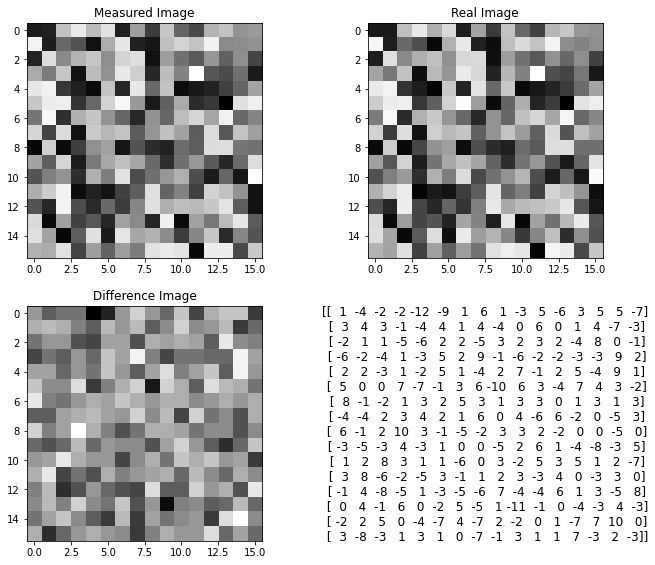

In [93]:
plot_to_compare(output_im, image)

## [OQIM] - Order-encoded quantum image model 

### Dependencies import

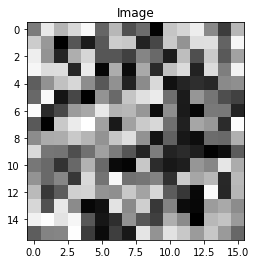

In [104]:
image = image_generate("normal")
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [105]:
im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
thetas = np.interp(im_list, (0, 256), (0, np.pi/2)) #intensity
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2)) #coordinate

In [106]:
num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1

### Quantum circuit building

In [107]:
O = QuantumRegister(num_ind_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c, p, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)
qc_image.h(p)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_3060\4229806161.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


In [108]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 4306, # of qubits is 10


In [109]:
wash_qc = transpile(circuits=qc_image, coupling_map=list(coupling_map)[0], basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))

depth is 242694


In [110]:
# qc_image.draw()

### Backend simulation

In [111]:
shots = 100000
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc_image, backend, shots)

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_3060\1756418184.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


### Input and measured images comparison

In [112]:
classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            if not int(key[1]):
                color_list.append((key[0], amount))
            else:
                coord_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)

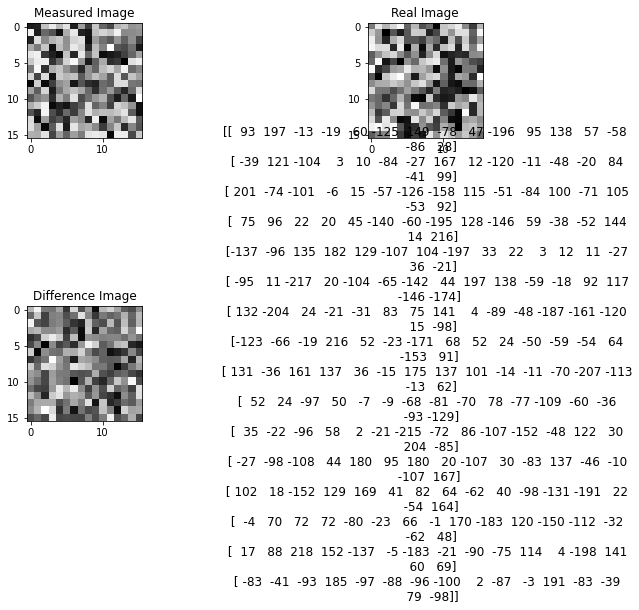

In [115]:
plot_to_compare(output_im, image)

# Discrete representation examples

## [NEQR] - Novel enhanced quantum representation of digital images

$| I \rangle = \frac{1}{2^n}\sum_{Y=0}^{2^n-1}\sum_{X=0}^{2^n-1}\bigotimes_{i=0}^{q-1} | C_{YX}^{i}\rangle | YX \rangle$, where

$| C_{YX}^{i}\rangle$ and $| YX \rangle$ are pixel intensity and coordinate expansion respectively

### Image generation

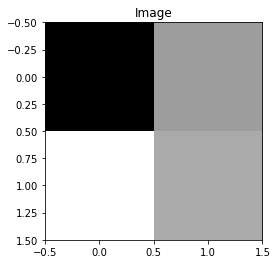

In [126]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

### Quantum circuit building

In [127]:
indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(intensity)
qc_image.h(indx)
for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord):
            qc_image.x(qc_image.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_image.x(qc_image.num_qubits-j-1)
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_3060\248905402.py:7: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.id as direct replacement.
  qc_image.i(intensity)


In [128]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 18, # of qubits is 10


In [129]:
wash_qc = transpile(circuits=qc_image, coupling_map=list(coupling_map)[0], basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))

depth is 301


In [130]:
# qc_image.draw()

### Backend simulation

In [131]:
shots = 8192
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc_image, backend, shots)

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_3060\1756418184.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


### Input and measured images comparison

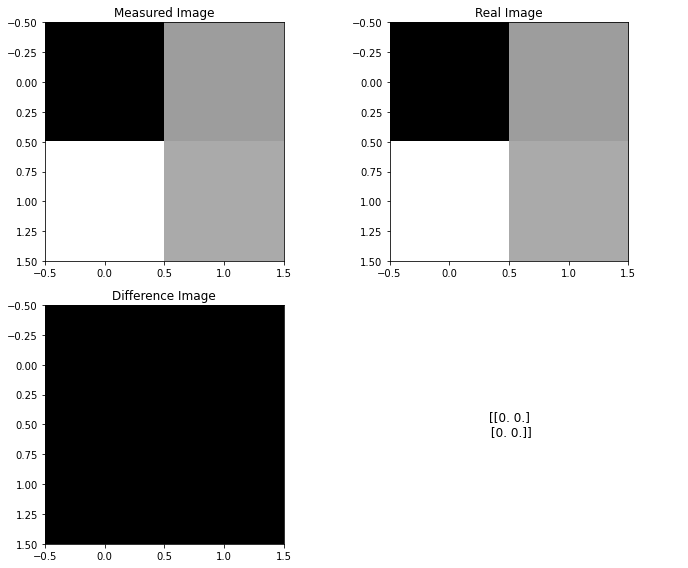

In [133]:
out_pixels = []
for item in counts:
    out_pixels.append((int(item[0:w_bits+h_bits], 2), int(item[w_bits+h_bits:],2)))
out_image = np.zeros((1, len(input_im)))
for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]
out_image = np.reshape(out_image, (image.shape))
plot_to_compare(out_image, image)

## [BRQI](https://www.overleaf.com/project/61911febed45e965f929d7c0#cite.li2018quantum) - Quantum image representation based on bitplanes

Image is assumed a collection of bitbpanes. Each image has 8 separate bitplanes (in a gray-scaled case). Every bitplane is discribed as follows:

$| \Psi_m^j \rangle = \frac{1}{2^n}\sum_{x=0}^{2^{n-k}-1}\sum_{y=0}^{2^k-1} | g(x,y) \rangle |x \rangle | y \rangle$, where

$\Psi_m^j$ - bitplane representation;

$j = (0,... 7)$ - number of bitplane;

$m = 1$ (in gray scaled case) - band number;

$g(x,y) = (0,1)$ - pre-/absence if $j^{th}$ bitplane in the band $m$

### Image generation

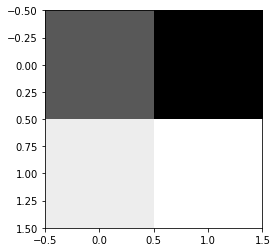

In [134]:
image = image_generate("smallest")
plt.imshow(image, cmap = 'gray')
plt.show()

In [135]:
w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1
color_n_b = 8
color_n_b = int(np.ceil(math.log(color_n_b,2)))

### Quantum circuit building

In [136]:
color = QuantumRegister(1, 'color')
y_ax = QuantumRegister(w_bits, 'y axis')
x_ax = QuantumRegister(h_bits, 'x axis')
bitplane_q = QuantumRegister(color_n_b, 'bitplanes')
classic = ClassicalRegister(1+w_bits+h_bits+color_n_b, 'classic')
qc = QuantumCircuit(color, y_ax, x_ax, bitplane_q, classic)

qc.i(color)
qc.h(x_ax)
qc.h(y_ax)
qc.h(bitplane_q)

qc.barrier()

for bitplane in range(8):
    bit_bitplane = "{0:b}".format(bitplane).zfill(color_n_b)
    for n, bit in enumerate(bit_bitplane):
        if bit!='1':
            qc.x(bitplane_q[n])
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel = "{0:b}".format(image[i,j]).zfill(8)
            if pixel[bitplane]=='1':
                i_bit = "{0:b}".format(i).zfill(h_bits)
                for i_n, ibit in enumerate(i_bit):
                    if ibit!='1':
                        qc.x(x_ax[i_n])
                    j_bit = "{0:b}".format(j).zfill(w_bits)
                for j_n, jbit in enumerate(j_bit):
                    if jbit!='1':
                        qc.x(y_ax[j_n])
                qc.barrier()

                controls = list(range(color.size,
                                      qc.num_qubits))
                xg = XGate(None).control(len(controls))
                controls.append(color)
                qc.append(xg, controls)

                for j_n, jbit in enumerate(j_bit):
                    if jbit!='1':
                        qc.x(y_ax[j_n])

                for i_n, ibit in enumerate(i_bit):
                        if ibit!='1':
                            qc.x(x_ax[i_n])
                qc.barrier()

    for n, bit in enumerate(bit_bitplane):
        if bit!='1':
            qc.x(bitplane_q[n])
qc.barrier()
qc.measure(list(reversed(range(qc.num_qubits))), list(range(classic.size)))

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_3060\2513318362.py:8: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.id as direct replacement.
  qc.i(color)


In [138]:
wash_qc = transpile(circuits=qc, coupling_map=list(coupling_map)[0], basis_gates=basis_gates)#, optimization_level=2)
print("depth is {}".format(wash_qc.depth()))

depth is 3992


In [139]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

depth is 46, # of qubits is 6


### Backend simulation

In [140]:
shots = 1000000
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc_image, backend, shots)

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_3060\1756418184.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


### Input and measured images comparison

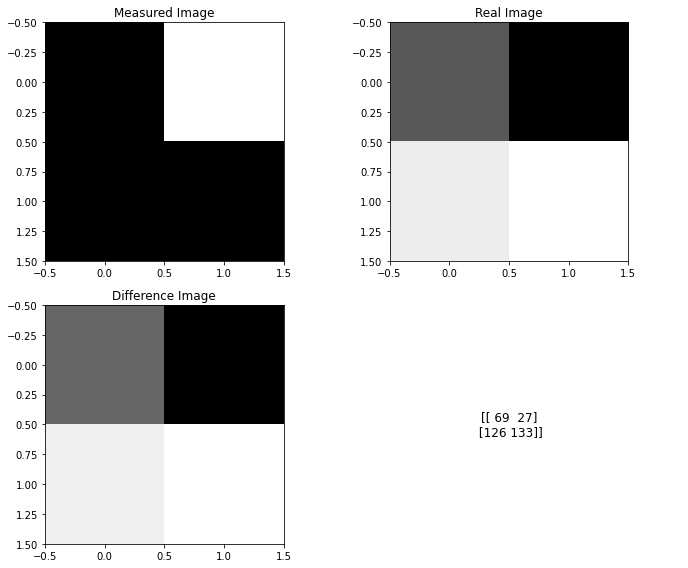

In [141]:
out_pixels = []
for item in counts:
    out_pixels.append((int(item[0:color.size], 2),
                       int(item[color.size:color.size+x_ax.size],2),
                       int(item[color.size+x_ax.size:color.size+x_ax.size+y_ax.size],2),
                       int(item[color.size+x_ax.size+y_ax.size:qc.num_qubits],2)
                     ))
out_image = []
for k in range(image.shape[0]):
    for j in range(image.shape[1]):
        bits = [i for i in range(len(out_pixels)) if out_pixels[i][1] == k and out_pixels[i][2] == j]
        pixel = np.zeros((8,))
        for bit in bits:
            pixel[out_pixels[bit][3]] = int(out_pixels[bit][0])
        mystring = "".join([str(int(a)) for a in pixel])
        out_image.append(int(mystring, 2))
out_image = np.array(out_image).reshape(image.shape[1], image.shape[0])
plot_to_compare(out_image, image)

## GQIR 

### Image generation

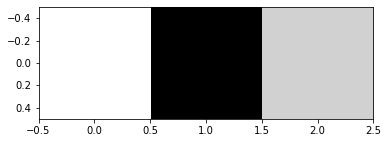

In [142]:
image = np.random.uniform(low=0, high=255, size=(1,3)).astype(int)
plt.imshow(image, cmap = 'gray')

### Quantum circuit building

In [143]:
x = int(np.ceil(math.log(image.shape[0], 2)))
if int(x) == 0: x = 1
y = int(np.ceil(math.log(image.shape[1], 2)))
if int(y) == 0: y = 1
q = 8

color = QuantumRegister(q, 'color')
y_ax = QuantumRegister(y, 'y axis')
x_ax = QuantumRegister(x, 'x axis')
classic = ClassicalRegister(x+y+q, 'classic')
qc = QuantumCircuit(color, y_ax, x_ax, classic)

qc.i(color)
qc.h(x_ax)
qc.h(y_ax)
qc.barrier()
controls_ = []
for i, _ in enumerate(x_ax):
    controls_.extend([x_ax[i]])
for i, _ in enumerate(y_ax):
    controls_.extend([y_ax[i]])  
for xi in range(image.shape[0]):
    xi_bin = "{0:b}".format(xi).zfill(x_ax.size)
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc.x(x_ax[i])  
    qc.barrier()
    for yi in range(image.shape[1]):
        yi_bin = "{0:b}".format(yi).zfill(y_ax.size)
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc.x(y_ax[i]) 
        qc.barrier()
        intensity_bin = "{0:b}".format(image[xi, yi]).zfill(len(color))
        xg = XGate(None).control(len(controls_))
        target = []
        for i, bit in enumerate(intensity_bin):
            if int(bit):
                qc.mcx(controls_, color[i])
        qc.barrier()
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc.x(y_ax[i])
        qc.barrier()
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc.x(x_ax[i])
    qc.barrier()

qc.measure(x_ax, range(x_ax.size))
qc.measure(y_ax, range(x_ax.size, x_ax.size+y_ax.size))
qc.measure(color, range(x_ax.size+y_ax.size,x_ax.size+y_ax.size+color.size))

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_3060\3398955442.py:13: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.id as direct replacement.
  qc.i(color)


In [144]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

depth is 22, # of qubits is 11


In [148]:
wash_qc = transpile(circuits=qc, coupling_map=list(coupling_map)[0], basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))

depth is 798


### Backend simulation

In [149]:
shots = 80000
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc_image, backend, shots)
counts = (["".join(list(reversed(c))) for c in counts])

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_3060\1756418184.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


### Input and measured images comparison

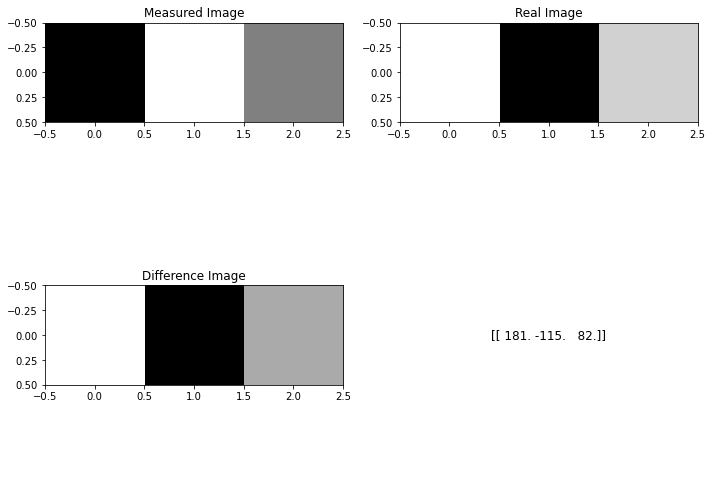

In [151]:
out_pixels = []
for item in counts:
    out_pixels.append((int(item[0:x], 2), int(item[x:x+y],2), int(item[-q:],2)))
out_image = np.zeros(image.shape)
for pixel in out_pixels:
    if pixel[0]<out_image.shape[0]:
        if pixel[1]<out_image.shape[1]:
            out_image[pixel[0], pixel[1]] = pixel[2]
plot_to_compare(out_image, image)